In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime,timedelta
%matplotlib inline
from pmdarima.arima.utils import ndiffs
from keras.models import Sequential
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
end_date = datetime.now()
stock_symbol = "GOOGL"
# Format the current date as "year-month-date"
# formatted_date = cend_date.strftime('%Y-%m-%d')
start_date = "2015-01-01"
end_date  = end_date.strftime('%Y-%m-%d')

In [3]:
df = yf.download(stock_symbol ,period='5y',interval='1d')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-24,57.970501,59.259499,57.575001,58.978001,58.978001,31150000
2018-09-25,59.212502,59.842999,58.704498,59.694500,59.694500,33152000
2018-09-26,59.684502,60.362000,59.270000,59.702999,59.702999,37650000
2018-09-27,60.000000,60.842999,59.902500,60.368000,60.368000,36274000
2018-09-28,60.204498,60.422501,59.891499,60.354000,60.354000,35612000
...,...,...,...,...,...,...
2023-09-18,136.610001,139.160004,136.610001,138.210007,138.210007,21861300
2023-09-19,137.419998,138.410004,136.619995,138.039993,138.039993,20353700
2023-09-20,138.080002,138.080002,133.619995,133.740005,133.740005,29927500


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-24,57.970501,59.259499,57.575001,58.978001,58.978001,31150000
2018-09-25,59.212502,59.842999,58.704498,59.694500,59.694500,33152000
2018-09-26,59.684502,60.362000,59.270000,59.702999,59.702999,37650000
2018-09-27,60.000000,60.842999,59.902500,60.368000,60.368000,36274000
2018-09-28,60.204498,60.422501,59.891499,60.354000,60.354000,35612000
...,...,...,...,...,...,...
2023-09-18,136.610001,139.160004,136.610001,138.210007,138.210007,21861300
2023-09-19,137.419998,138.410004,136.619995,138.039993,138.039993,20353700
2023-09-20,138.080002,138.080002,133.619995,133.740005,133.740005,29927500


## Checking Stationarity of the time series using ADF test

if p < 0.05 then the series is stationary else it is not

In [5]:
result = adfuller(df.Open.dropna())
print(f"ADF statistics:{result[0]}")
print(f"P values :{result[1]}")

ADF statistics:-0.8869393607746967
P values :0.792243040584462


##### since p is > 0.05 we need to difference them

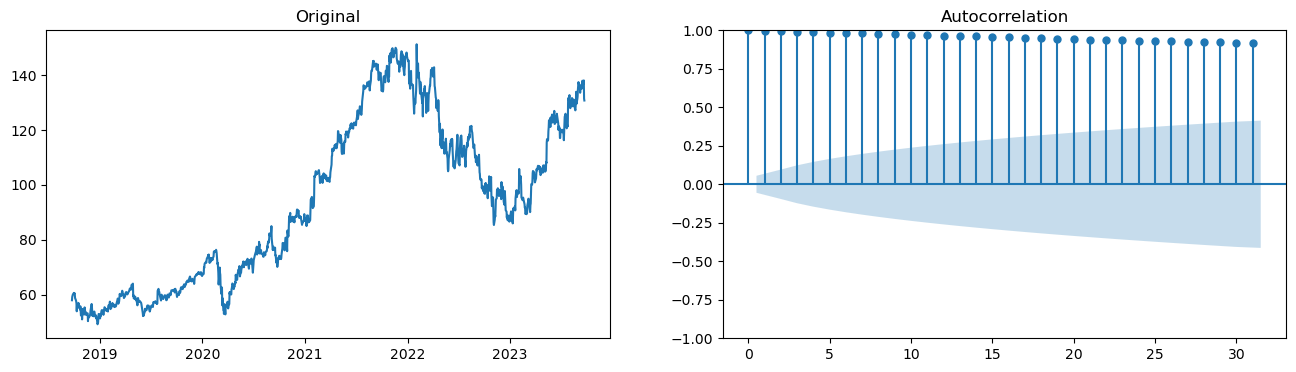

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df.Open)
ax1.set_title("Original")
plot_acf(df.Open,ax=ax2);

#### Differencing Once

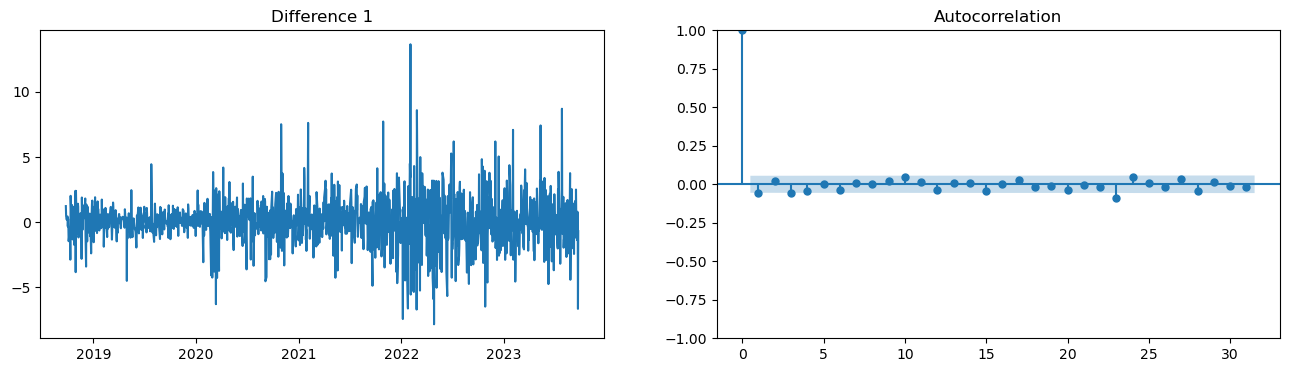

In [7]:
diff = df.Open.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference 1")
plot_acf(diff,ax=ax2);

#### Differencing Twice (Lag goes far away in negative so we choose only the 1st differencing)

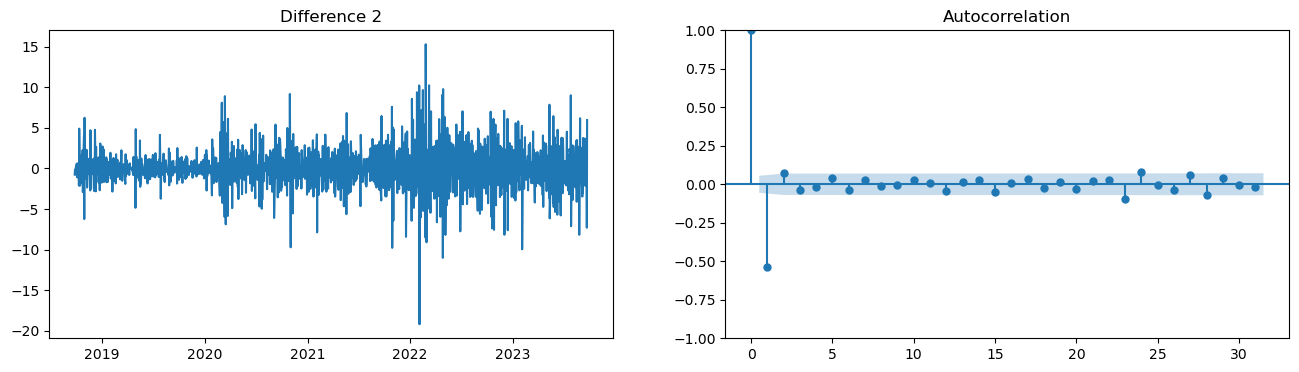

In [8]:
diff2 = df.Open.diff().diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff2)
ax1.set_title("Difference 2")
plot_acf(diff2,ax=ax2);

### D value is 3

In [9]:
ndiffs(df.Open,test="adf")

1

### P Autoregressive part (Number of lags) 
find which value stands above the line in partial autocorrelation

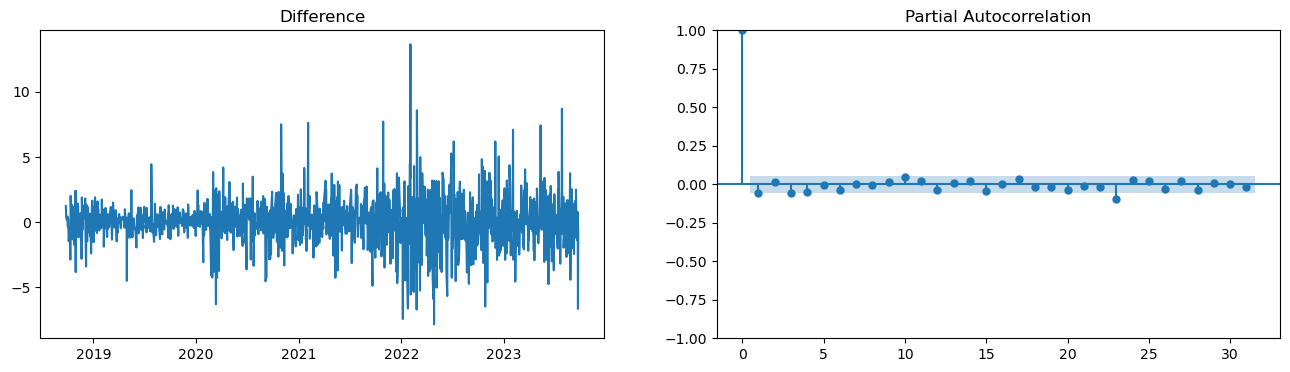

In [10]:
diff = df.Open.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2);

### Q term is the Moving Average Term (MA) 
value three is suitable here

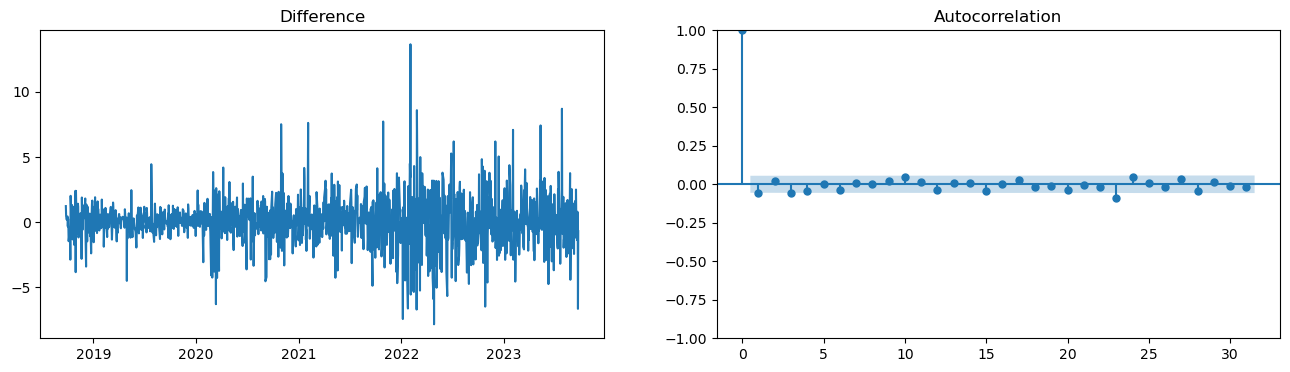

In [11]:
diff = df.Open.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference")
ax2.set_ylim(0,1)
plot_acf(diff,ax=ax2);

## ARIMA Model fitting

In [12]:
model = ARIMA(df["Open"],order=(6,1,3))
result = model.fit()

/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 1258
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -2563.889
Date:                Sun, 24 Sep 2023   AIC                           5147.778
Time:                        14:17:38   BIC                           5199.142
Sample:                             0   HQIC                          5167.082
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5505      0.058      9.440      0.000       0.436       0.665
ar.L2          0.5024      0.082      6.105      0.000       0.341       0.664
ar.L3         -0.9514      0.054    -17.732      0.000      -1.057      -0.846
ar.L4         -0.0558      0.028     -1.990      0.047      -0.111      -0.001
ar.L5          0.0531      0.030      1.756      0.079      -0.006       0.112
ar.L6         -0.0361      0.026     -1.396      0.163      -0.087       0.015
ma.L1         -0.6064      0.054    -11.198      0.000      -0.712      -0.500
ma.L2         -0.4634      0.083     -5.570      0.000      -0.626      -0.300
ma.L3          0.9390      0.054     17.462      0.000       0.834       1.044
sigma2         3.4617      0.084     41.303      0.000       3.297       3.626
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1051.70
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(array([0.03648935, 0.11530635, 0.00097305, 0.00012163, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00012163]),
 array([-7.38384581, -0.84841114,  5.68702354, 12.22245822, 18.75789289,
        25.29332757, 31.82876224, 38.36419692, 44.89963159, 51.43506627,
        57.97050095]),
 <BarContainer object of 10 artists>)

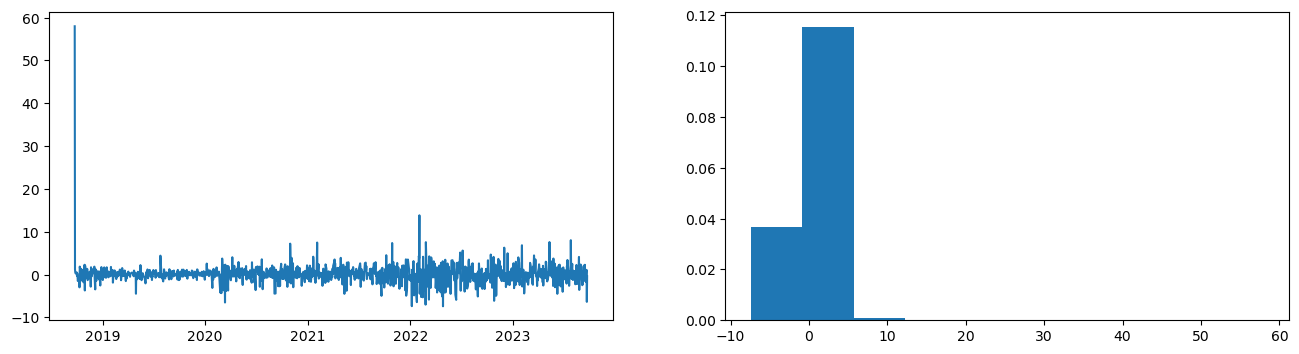

In [14]:
residuals = pd.DataFrame(result.resid)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals,density=True)

### Actual vs Fitted result

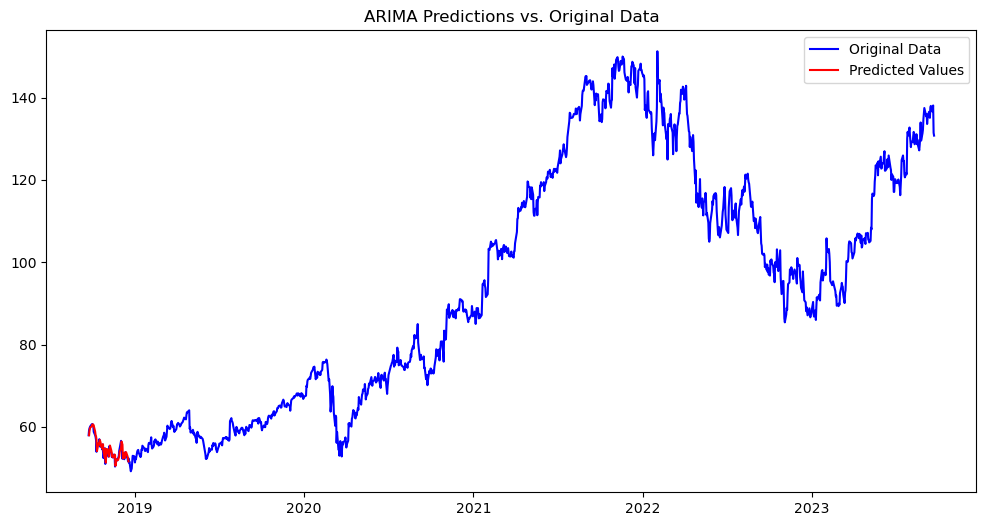

In [15]:
predicted_values = result.predict(start=1, end=60, dynamic=False)

# Plot the original data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Open'], label='Original Data', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.title('ARIMA Predictions vs. Original Data')
plt.show()

### Train Test Split


In [16]:
n =int(len(df)*0.8)
train = df.Open[:n]
test = df.Open[n:]

In [17]:
arimaModel = ARIMA(train,order=(6,1,3))
res = arimaModel.fit()

/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

In [18]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 1006
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -2011.289
Date:                Sun, 24 Sep 2023   AIC                           4042.578
Time:                        14:17:39   BIC                           4091.706
Sample:                             0   HQIC                          4061.246
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5680      0.218      2.608      0.009       0.141       0.995
ar.L2         -0.1032      0.271     -0.381      0.703      -0.633       0.427
ar.L3         -0.6274      0.191     -3.283      0.001      -1.002      -0.253
ar.L4         -0.0524      0.032     -1.627      0.104      -0.116       0.011
ar.L5          0.0440      0.029      1.529      0.126      -0.012       0.100
ar.L6         -0.0906      0.028     -3.288      0.001      -0.145      -0.037
ma.L1         -0.6307      0.221     -2.853      0.004      -1.064      -0.197
ma.L2          0.1600      0.286      0.559      0.576      -0.401       0.721
ma.L3          0.5527      0.210      2.626      0.009       0.140       0.965
sigma2         3.2032      0.083     38.417      0.000       3.040       3.367
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1438.76
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               7.01   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecasting

In [19]:
steps = 30
forecast = result.forecast(steps)
print(forecast)

1258    130.508803
1259    130.614176
1260    131.219303
1261    131.506147
1262    132.085589
1263    131.978311
1264    131.918379
1265    131.292494
1266    130.980944
1267    130.578368
1268    130.772427
1269    131.009014
1270    131.606109
1271    131.897573
1272    132.111989
1273    131.820012
1274    131.461940
1275    130.921004
1276    130.703050
1277    130.669104
1278    131.052308
1279    131.475292
1280    131.929359
1281    132.037115
1282    131.906827
1283    131.455196
1284    131.021868
1285    130.683178
1286    130.705294
1287    130.973968
Name: predicted_mean, dtype: float64


/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
forecast = result.get_forecast(steps)

# Access the forecasted values as a Pandas Series
forecast_values = forecast.predicted_mean

# Access the confidence intervals as a Pandas DataFrame
forecast_conf_int = forecast.conf_int()

# Extract the lower and upper bounds from the DataFrame
lower_bound = forecast_conf_int.iloc[:, 0]  # Lower bound
upper_bound = forecast_conf_int.iloc[:, 1]  # Upper bound

# 'lower_bound' and 'upper_bound' now contain the lower and upper bounds of the confidence intervals for each forecasted value.


/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

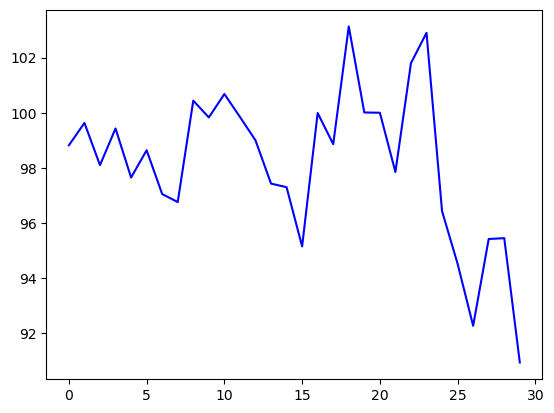

In [27]:
actual_values = test[:steps]

forecast_values = forecast

time_index = range(len(actual_values))
# Plot actual values
plt.plot(time_index, actual_values, label='Actual', color='blue')

# Plot ARIMA forecasts
plt.plot(time_index, forecast_values, label='ARIMA Forecast', color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs ARIMA Forecast')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

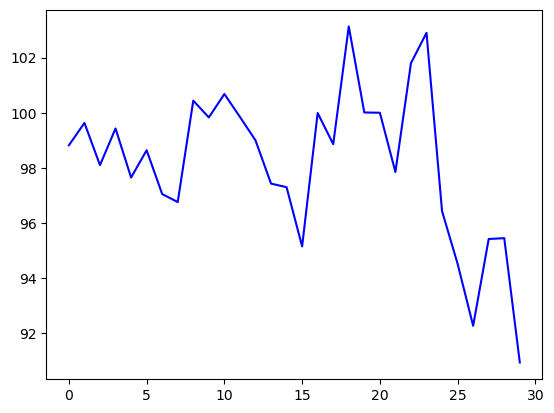

In [28]:
import matplotlib.pyplot as plt

# Assuming you have actual values and ARIMA forecasts
# Replace 'actual_values' and 'forecast_values' with your data
actual_values = test[:steps]  # Replace with your actual data
forecast_values = forecast  # Replace with your forecasted data

# Create a time index for the x-axis (e.g., using range)
time_index = range(len(actual_values))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual', color='blue')

# Plot ARIMA forecasts
plt.plot(time_index, forecast_values, label='ARIMA Forecast', color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs ARIMA Forecast')
plt.show()
